 ### This notebook contains an exporatory data analysis over the source dataset

In [1]:
# required imports
import pandas as pd
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.feature_extraction import text 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize



In [2]:
# dataset is loaded into different dataframes
df_test = pd.read_csv("data/test.txt", sep=";", names=['phrase', 'feeling'])
df_train = pd.read_csv("data/train.txt", sep=";", names=['phrase', 'feeling'])
df_val = pd.read_csv("data/val.txt", sep=";", names=['phrase', 'feeling'])

# dataframes are joined
df = pd.concat([df_test, df_train, df_val])

# confirm which emotions are present on the data
print(df.feeling.unique())

['sadness' 'joy' 'fear' 'anger' 'love' 'surprise']


In [3]:
# data cleaning step

# function to clean text based on:
# - making all text lowercase
# - remove punctuation
# - remove numbers
# - remove common non-sensical text (e.g. /n)
# - remove 1 char words
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"\b[a-zA-Z]\b", "", text)
    return text

# cleaning function is created as lambda
cleaning_lambda = lambda x: clean_text(x)

# lambda cleaning is applied to each phrase in the dataframe
# to obtain a new dataframe with clean phrases
data_clean = pd.DataFrame(df.phrase.apply(cleaning_lambda))
data_clean['feeling'] = df.feeling
data_clean = data_clean.groupby(['feeling'])['phrase'].apply(' '.join).reset_index()
data_clean.index = data_clean.feeling
data_clean


,feeling,phrase
feeling,,
anger,anger,felt anger when at the end of telephone call...
fear,fear,cant walk into shop anywhere where do not f...
joy,joy,left with my bouquet of red and yellow tulips...
love,love,find myself in the odd position of feeling su...
sadness,sadness,im feeling rather rotten so im not very ambiti...
surprise,surprise,feel little stunned but can imagine what th...


In [4]:
# document term matrix is created
# which means, in simple words, we count each word

# we use stop words in english because the dataset 
# contains english phrases
cv = CountVectorizer(stop_words='english')

data_cv = cv.fit_transform(data_clean.phrase)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())

# get total of words
print("total words in dataset")
print(data_dtm.values.sum())
data_dtm.index = data_clean.feeling
print("total words after grouping")
print(data_dtm.loc[:, data_dtm.columns != 'the_feeling'].values.sum())



total words in dataset
168154
total words after grouping
168154


In [5]:
# then the document term matrix is transposed
# so that is easier to operate over columns
data_dtm_transposed = data_dtm.transpose()

print("total words per feeling")
print(data_dtm_transposed.sum())



total words per feeling
feeling
anger       22715
fear        19607
joy         57662
love        14713
sadness     47220
surprise     6237
dtype: int64


In [6]:
# finding total of unique words

unique_list = []
for feeling in data_dtm_transposed.columns:
    uniques = data_dtm_transposed[feeling].to_numpy().nonzero()[0].size
    unique_list.append(uniques)

unique_words = pd.DataFrame(list(zip(data_clean.feeling, unique_list)), columns=['feel', 'unique_words'])
unique_words_sort = unique_words.sort_values(by='unique_words')

print("total unique words per feeling")
print(unique_words_sort)


total unique words per feeling
       feel  unique_words
5  surprise          2235
3      love          4134
1      fear          4659
0     anger          5217
4   sadness          7643
2       joy          9519


In [8]:
# finding most common words for each feeling
top_dict = {}
for c in data_dtm_transposed.columns:
    top = data_dtm_transposed[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

# for reference, we print the most common words
for feeling, top_words in top_dict.items():
    print(feeling)
    print(', '.join([word for word, count in top_words]))
    print('---')
    
words = []
for feeling in data_dtm_transposed.columns:
    top = [word for (word, count) in top_dict[feeling]]
    for t in top:
        words.append(t)
        

# the most common words are removed if shared by 2 or more feelings
add_stop_words = [word for word, count in Counter(words).most_common() if count > 1]
add_stop_words

# most common words are added as stop words 
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# and are removed 
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(data_clean.phrase)
data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_stop.index = data_clean.index


anger
feel, feeling, like, im, just, really, know, people, time, little, want, think, angry, things, bit, way, don, dont, cold, irritable, bothered, going, ive, greedy, resentful, insulted, offended, life, need, pissed
---
fear
feel, feeling, im, like, just, little, bit, know, really, time, people, want, anxious, strange, terrified, nervous, think, going, ive, afraid, scared, weird, unsure, things, vulnerable, apprehensive, overwhelmed, uncertain, dont, shaken
---
joy
feel, feeling, like, im, just, really, time, know, make, people, want, good, little, think, pretty, life, love, going, ive, day, happy, dont, things, way, need, work, did, right, today, don
---
love
feel, feeling, like, im, just, love, really, know, sweet, loving, time, want, people, caring, passionate, sympathetic, life, liked, hot, little, feelings, tender, lovely, longing, loved, need, accepted, nostalgic, horny, gentle
---
sadness
feel, feeling, like, im, just, really, know, ive, little, time, want, life, bit, people,

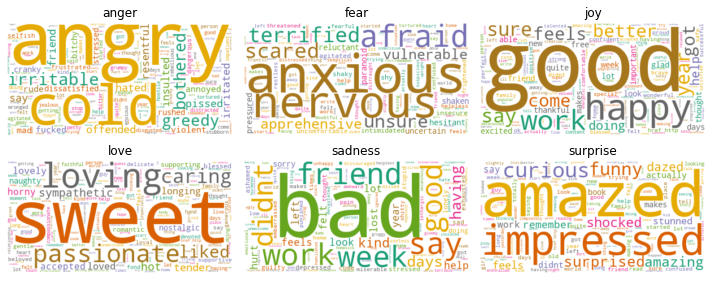

In [9]:

# for easy visualization, wordclouds are created
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

plt.rcParams['figure.figsize'] = [10, 6]

# one cloud plot per feeling 
for index, feeling in enumerate(data_dtm_transposed.columns):
    wc.generate(data_clean.phrase[feeling])
    
    plt.subplot(3, 3, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(feeling)
    
plt.tight_layout()
plt.savefig("exploratory_data_analysis_clouds.png")
plt.show()